# An analysis of the State of the Union speeches - Part 1

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Reading text file to extract address metadata, line-by-line
data = []
fp = open("data/stateoftheunion1790-2017.txt")
#open the data through relative path and save it in fp 
for i, line in enumerate(fp):
#use for loop to extrace the data from each line
    if i >= 10 and i < 237:
        datadict = {}
        datadict['president'] = line.split(',')[0].strip()
        datadict['title'] = line.split(',')[1].strip()
        datadict['date'] = line.split(',')[2].strip() + ' ' + line.split(',')[3].strip()
#pull out the president column(0 column), title column(column 1), and date column(column 2) by splitiing the words with ","
        data.append(datadict)
#adding all data together
fp.close()
#close the fp file
addresses = pd.DataFrame(data)

# reordering dataframe and converting 'date' column to datetime values
addresses = addresses[['president', 'title', 'date']]
addresses['date'] = pd.to_datetime(addresses.date)
#add date column in addresses.date into data frame addresses

In [3]:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


In [4]:
# Describing presidents column
addresses.president.describe()

count                       227
unique                       42
top       Franklin D. Roosevelt
freq                         12
Name: president, dtype: object

In [5]:
# Number of years between first and last address
(addresses.date[-1:] - addresses.date[0]).dt.days.values[0] / 365

227.2876712328767

In [6]:
acounts = addresses.date.dt.strftime('%B').value_counts()[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']].replace(np.nan, 0).astype('int64')
#add months from Jan to Dec and the value of number of counts
acounts.name = 'Address counts'
acounts

January       75
February      12
March          0
April          0
May            0
June           0
July           0
August         0
September      2
October        3
November      11
December     124
Name: Address counts, dtype: int64

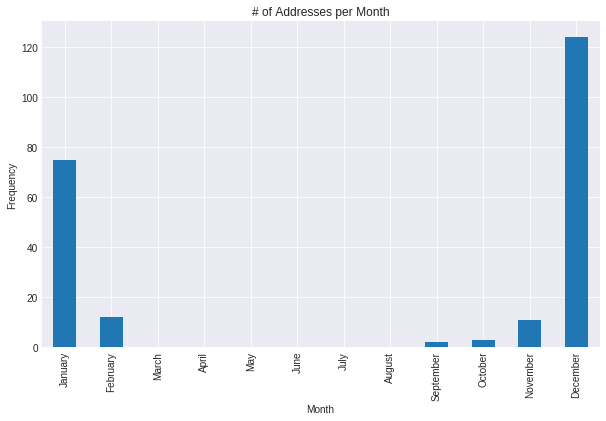

In [7]:
acounts.plot(kind='bar', style='seaborn-dark', grid=True, title='# of Addresses per Month', )
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.savefig('fig/addresses_month.png');
#use seaborn to draw the distributions of number of counts for each year.
#x-axis as month, and y-axis is the frequency of number of speeches

Let's look at the distribution of differences between successive speeches:

Where is the largest gap? We can ask the `ddiff` series for its location:

In [8]:
dgap = addresses.date.diff().loc[addresses.date.diff() == addresses.date.diff().max()].index.values[0]

In [9]:
# this is the index of the largest gap:
dgap

104

Let's look at the dates around this index:

In [10]:
addresses.date[dgap-2 : dgap+2]
#call the rolls that have gap of four years, and we figure out there is a 4 years gap 

102   1891-12-09
103   1892-12-06
104   1897-12-06
105   1898-12-05
Name: date, dtype: datetime64[ns]

As well as a plot of these times:

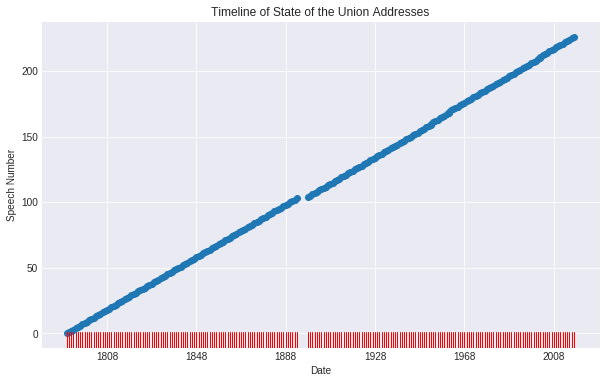

In [11]:
plt.scatter(x=addresses.date.values, y=addresses.index.values)
plt.grid()
plt.title("Timeline of State of the Union Addresses")
plt.ylabel("Speech Number")
plt.xlabel("Date")
sns.rugplot(addresses.date.values, color='red')
plt.savefig('fig/timeline.png')
#use scatter plot for speech numbers in different years, and we have noticed that there is a breaking 
#point in the middle.

There is a gap between the year of 1892 to 1897, because the data is imperfected.  As we google search the president during that era, Grover Cleveland was the president during that time. It appears the dataset is missing the State of the Union Addresses from Grover Cleveland's second term, which is 1892-1897, and that is the reason why there is a gap in between.

In [12]:
addresses.loc[addresses.date[dgap-2 : dgap+2].index]
#similarly to what we did, the index showed the gap between 1892-1897.

,president,title,date
102,Benjamin Harrison,State of the Union Address,1891-12-09
103,Benjamin Harrison,State of the Union Address,1892-12-06
104,William McKinley,State of the Union Address,1897-12-06
105,William McKinley,State of the Union Address,1898-12-05


In [13]:
addresses.loc[addresses.president == 'Grover Cleveland']
#We have searched it on the google, and it showed that the year 1892-1897 is Grover's term, and 
#so we called the president Grover Cleveland, and only 1885-1888 showed up.

,president,title,date
96,Grover Cleveland,State of the Union Address,1885-12-08
97,Grover Cleveland,State of the Union Address,1886-12-06
98,Grover Cleveland,State of the Union Address,1887-12-06
99,Grover Cleveland,State of the Union Address,1888-12-03


It appears the dataset is missing the State of the Union Addresses from Grover Cleveland's second term, since there is only one period of Grover's presidency from 1885-1888.

## Intermediate results

Let's save some intermediate results for further analysis. This lets us work on subsequent notebooks  without rerunning this one.  We use the Pandas HDF5 support for efficient and type-safe serialization of data frames, and the python builtin [shelve](https://docs.python.org/3/library/shelve.html) module for simple Python variables.  We'll create for each notebook variable stores with the notebook number, one for dataframes (`df1.h5`, `df2.h5`, etc.) and one for python variables (`vars1.db`, `vars2.db`, etc.).  These will all go into the `results/` subdirectory.

In [14]:
with open('data/stateoftheunion1790-2017.txt', 'r') as file:
    speeches=file.read().split('***')[1:]

for i in range(len(speeches)):
    speeches[i] = ''.join(speeches[i])
    #open the speeches file and join the data from speeches file line-by-line to the new speeches
    #using for loop.

In [15]:
addresses.to_hdf('results/df1.h5', 'addresses')

with shelve.open('results/vars1') as db:
    db['speeches'] = speeches
    #store the result as df1.h5 and addresses.  Open the results vars1 to store the new
    #data speeches into the database.